In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import datetime
import numerapi

from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import scipy
import numpy
from scipy import stats

import lightgbm as lgb

import sys
sys.path.append("C:/Users/tyrab/tyler_python/numerai_public/")

from dataframe_functions.scoring_functions import score, payout

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Quick Points on Numerai Data Science Tournament
-Your model predictions will be scored on the spearman correlation against the actual targets

# Download Data via Numerapi

In [2]:
# some API calls do not require logging in
napi = numerapi.NumerAPI(verbosity="info")

In [3]:
# !pip install --user --upgrade  pyOpenSSL 

In [4]:
# get competitions
all_competitions = napi.get_competitions()
# get leaderboard for the current round
leaderboard = napi.get_leaderboard()
# check if a new round has started
if napi.check_new_round():
    print("new round has started wihtin the last 24hours!")
else:
    print("no new round within the last 24 hours")

2022-05-01 15:26:27,077 INFO numerapi.base_api: getting rounds...
C:\Users\tyrab\AppData\Roaming\Python\Python37\site-packages\cryptography\hazmat\backends\openssl\x509.py:17: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  utils.DeprecatedIn35,


no new round within the last 24 hours


In [5]:
# download current dataset
napi.download_current_dataset(unzip=True)

2022-05-01 15:26:28,757 INFO numerapi.utils: starting download
.\numerai_dataset_314.zip: 100%|███████████████████████████████████████████████████▉| 454M/454M [00:46<00:00, 8.79MB/s]2022-05-01 15:27:15,271 INFO numerapi.base_api: unzipping file...
.\numerai_dataset_314.zip: 454MB [01:00, 8.79MB/s]                                                                     

'.\\numerai_dataset_314.zip'

In [6]:
tournament_number = napi.get_current_round()
TOURNAMENT_NAME = "nomi"
TARGET_NAME = "target"
PREDICTION_NAME = "prediction"

In [7]:
training_data = pd.read_csv("./numerai_dataset_"+str(tournament_number)+"/numerai_training_data.csv")
tournament_data = pd.read_csv("./numerai_dataset_"+str(tournament_number)+"/numerai_tournament_data.csv")

In [8]:
training_data['erano'] = training_data.era.str.strip('era').astype('int')

validation_data = tournament_data[tournament_data.data_type == 'validation'].reset_index(drop=True)
validation_data['erano'] = validation_data.era.str.strip('era').astype('int')

## Target is linear and looks somewhat discrete normally distributed

<AxesSubplot:>

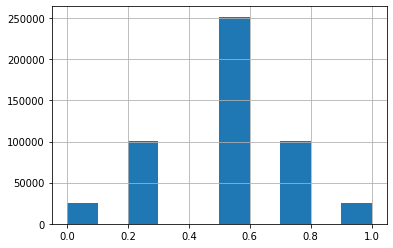

In [51]:
training_data.target.hist()

## Features are discrete and look almost uniform except for 0.5

<AxesSubplot:>

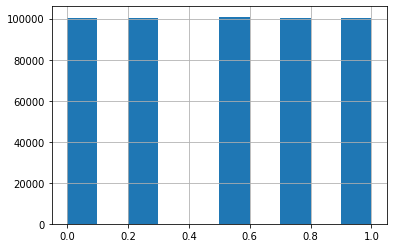

In [52]:
training_data.feature_constitution85.hist()

## Data is cleaned and standardized already - this was to hide the features being used from the modelers (stock market data)

In [53]:
training_data.describe()

,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,...,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target,erano,prediction
count,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,...,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000
mean,0.499981,0.499979,0.499979,0.499981,0.499977,0.499977,0.499977,0.499981,0.499980,0.499980,...,0.499974,0.499980,0.499982,0.499980,0.499974,0.499979,0.499971,0.499997,64.001987,0.485555
std,0.353596,0.353593,0.353593,0.353596,0.353587,0.353587,0.353587,0.353596,0.352099,0.352099,...,0.351328,0.350662,0.352151,0.352965,0.351328,0.347689,0.353419,0.223268,33.332945,0.110894
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,...,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.500000,37.000000,0.411265
50%,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,64.000000,0.484671
75%,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,...,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.500000,93.000000,0.558625
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,120.000000,1.000000


## Each erano represents a non-overlapping time period - check obs count

In [54]:
train_val_combined = training_data.append(validation_data)

<BarContainer object of 120 artists>

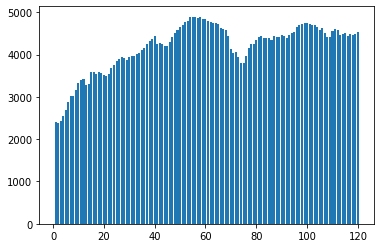

In [55]:
obs_count = train_val_combined.groupby('erano').target.count()
plt.bar(obs_count.index, obs_count.values)

# Lets Take a Closer Look at the Features and correlation with the target

In [56]:
features = [f for f in train_val_combined.columns if 'feature' in f]

In [57]:
corrs_by_era = train_val_combined.groupby(['data_type', 'erano']).corr(method='spearman')

In [58]:
corrs_by_era.head()

feature_intelligence1  \
data_type erano                                                
train     1.0   feature_intelligence1               1.000000   
                feature_intelligence2              -0.183064   
                feature_intelligence3              -0.215442   
                feature_intelligence4               0.605645   
                feature_intelligence5              -0.030718   

                                       feature_intelligence2  \
data_type erano                                                
train     1.0   feature_intelligence1              -0.183064   
                feature_intelligence2               1.000000   
                feature_intelligence3               0.915525   
                feature_intelligence4              -0.265463   
                feature_intelligence5               0.202574   

                                       feature_intelligence3  \
data_type erano                                                
train     1.0   feature_intelligence1              -0.215442   
                feature_intelligence2               0.915525   
                feature_intelligence3               1.000000   
                feature_intelligence4              -0.275010   
                feature_intelligence5               0.181403   

                                       feature_intelligence4  \
data_type erano                                                
train     1.0   feature_intelligence1               0.605645   
                feature_intelligence2              -0.265463   
                feature_intelligence3              -0.275010   
                feature_intelligence4               1.000000   
                feature_intelligence5              -0.021586   

                                       feature_intelligence5  \
data_type erano                                                
train     1.0   feature_intelligence1              -0.030718   
                feature_intelligence2               0.202574   
                feature_intelligence3               0.181403   
                feature_intelligence4              -0.021586   
                feature_intelligence5               1.000000   

                                       feature_intelligence6  \
data_type erano                                                
train     1.0   feature_intelligence1               0.163346   
                feature_intelligence2              -0.103570   
                feature_intelligence3              -0.094645   
                feature_intelligence4               0.075758   
                feature_intelligence5              -0.010793   

                                       feature_intelligence7  \
data_type erano                                                
train     1.0   feature_intelligence1               0.212536   
                feature_intelligence2              -0.074097   
                feature_intelligence3              -0.089664   
                feature_intelligence4               0.102740   
                feature_intelligence5              -0.041719   

                                       feature_intelligence8  \
data_type erano                                                
train     1.0   feature_intelligence1               0.678290   
                feature_intelligence2              -0.211914   
                feature_intelligence3              -0.221876   
                feature_intelligence4               0.845787   
                feature_intelligence5              -0.021586   

                                       feature_intelligence9  \
data_type erano                                                
train     1.0   feature_intelligence1              -0.391481   
                feature_intelligence2               0.491987   
                feature_intelligence3               0.474907   
                feature_intelligence4              -0.396227   
                feature_intelligence5               0.107444   

In [59]:
# Do some manipulation to get in a better format
corrs_by_era1 = corrs_by_era.reset_index()
corrs_by_era1 = corrs_by_era1.set_index(['data_type', 'erano', 'level_2']) 
corrs_by_era_w_target = corrs_by_era1['target'].reset_index()
corrs_by_era_w_target = corrs_by_era_w_target.rename(columns={'level_2': 'feature', 'target': 'correlation'})
corrs_by_era_w_target = corrs_by_era_w_target[(corrs_by_era_w_target.feature.isin(features))]

In [60]:
avg_corr = corrs_by_era_w_target.groupby('feature').correlation.mean().reset_index()
avg_std = corrs_by_era_w_target.groupby('feature').correlation.std().reset_index()
avg_skew = corrs_by_era_w_target.groupby('feature').correlation.skew().reset_index()
avg_std = avg_std.rename(columns={'correlation': 'stddev'})
avg_skew = avg_skew.rename(columns={'correlation': 'skewness'})
avg_corr_std = avg_corr.merge(avg_std, left_on = 'feature', right_on = 'feature')
avg_corr_std_skew = avg_corr_std.merge(avg_skew, left_on = 'feature', right_on = 'feature') 

In [62]:
# Add a color to the feature groups 
cat_group = []
for feat in avg_corr_std_skew.feature:
    if 'intelligence' in feat:
        cat_group += ['intelligence']
    elif 'charisma' in feat:
        cat_group += ['charisma']
    elif 'strength' in feat:
        cat_group += ['strength']
    elif 'dexterity' in feat:
        cat_group += ['dexterity']
    elif 'constitution' in feat:
        cat_group += ['constitution']
    elif 'wisdom' in feat:
        cat_group += ['wisdom']
        
avg_corr_std_skew['feat_cat_group'] = cat_group

conditions = [
    (avg_corr_std_skew['feat_cat_group'] == 'charisma'),
    (avg_corr_std_skew['feat_cat_group'] == 'constitution'),
    (avg_corr_std_skew['feat_cat_group'] == 'dexterity'),
    (avg_corr_std_skew['feat_cat_group'] == 'intelligence'),
    (avg_corr_std_skew['feat_cat_group'] == 'strength'),
    (avg_corr_std_skew['feat_cat_group'] == 'wisdom')
    ]

# create a list of the values we want to assign for each condition
values = ['red', 'blue', 'green', 'yellow', 'orange', 'black']

# create a new column and use np.select to assign values to it using our lists as arguments
avg_corr_std_skew['color'] = np.select(conditions, values)

In [63]:
avg_corr_std_skew['sharpe'] = avg_corr_std_skew.stddev/abs(avg_corr_std_skew.correlation)
avg_corr_std_skew = avg_corr_std_skew.sort_values(by='correlation')

<AxesSubplot:>

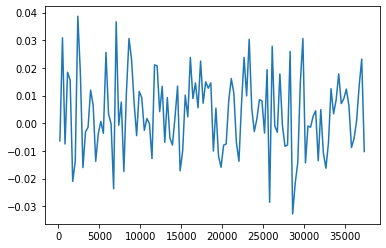

In [68]:
corrs_by_era_w_target[corrs_by_era_w_target.feature == 'feature_constitution35'].correlation.plot()

# There are some interesting properties of the features
### I will stop here as to not reveal anything too cool :)

<BarContainer object of 310 artists>

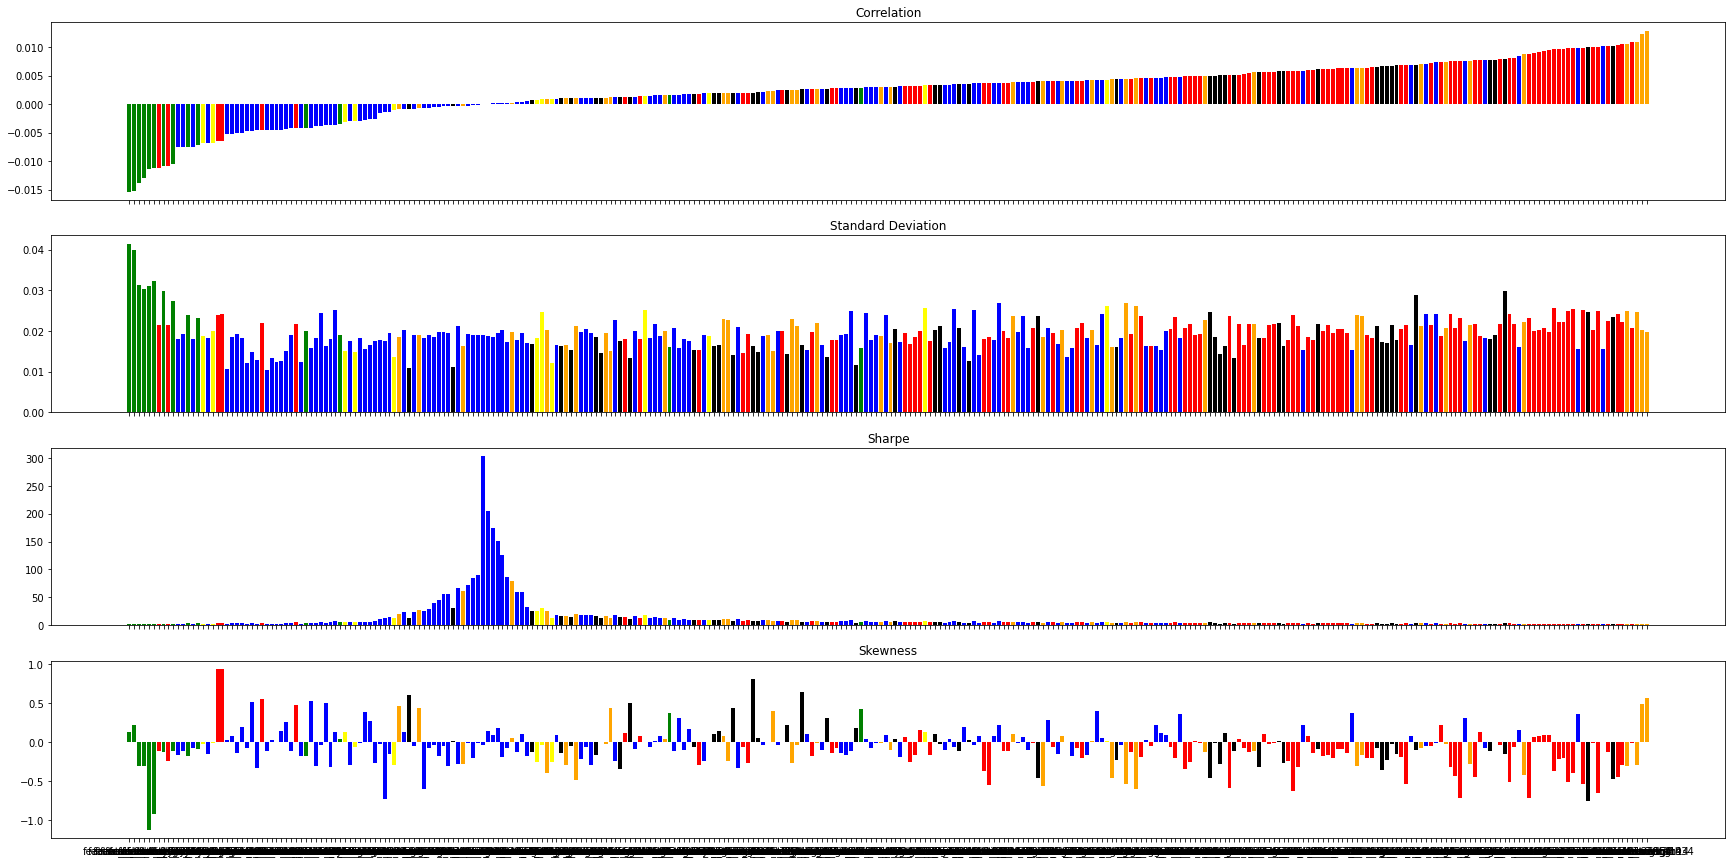

In [64]:
fig, ax = plt.subplots(4,1, figsize=(30,15), sharex=True)
ax[0].set_title('Correlation')
ax[0].bar(avg_corr_std_skew.feature, avg_corr_std_skew.correlation, color=avg_corr_std_skew.color)
ax[1].set_title('Standard Deviation')
ax[1].bar(avg_corr_std_skew.feature, avg_corr_std_skew.stddev, color=avg_corr_std_skew.color)
ax[2].set_title('Sharpe')
ax[2].bar(avg_corr_std_skew.feature, avg_corr_std_skew.sharpe, color=avg_corr_std_skew.color)
ax[3].set_title('Skewness')
ax[3].bar(avg_corr_std_skew.feature, avg_corr_std_skew.skewness, color=avg_corr_std_skew.color)

# Lets build a no thinking GBM model and see how it performs train and validation

In [324]:
# Submissions are scored by spearman correlation
def score(df):
    # method="first" breaks ties based on order in array
    pct_ranks = df[PREDICTION_NAME].rank(pct=True, method="first")
    targets = df[TARGET_NAME]
    return np.corrcoef(targets, pct_ranks)[0, 1]


# Payout is just the score cliped at +/-25%
def payout(scores):
    return scores.clip(lower=-0.25, upper=0.25)

In [321]:
clf = lgb.LGBMRegressor(n_estimators=100, max_depth = 2, learning_rate = 0.05, colsample_bytree = 0.1)

In [322]:
clf.fit(training_data[features], training_data[target])

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.1,
              importance_type='split', learning_rate=0.05, max_depth=2,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [323]:
training_data['prediction'] = clf.predict(training_data[features])
validation_data['prediction'] = clf.predict(validation_data[features])

In [325]:
train_corrs = training_data.groupby("erano").apply(score)
val_corrs = validation_data.groupby("erano").apply(score)

In [347]:
print(train_corrs.mean(), train_corrs.std())

0.05080540644118845 0.033128182501367474


In [348]:
print(val_corrs.mean(), val_corrs.std())

0.016887977875259703 0.03046571752976219


# Simple model performs better on train that val (no surprise here)

 - Some eras still have negative correlation during train
 - Validation has a large time gap, seems like eras > 200 are under a different regime than the train 

<BarContainer object of 28 artists>

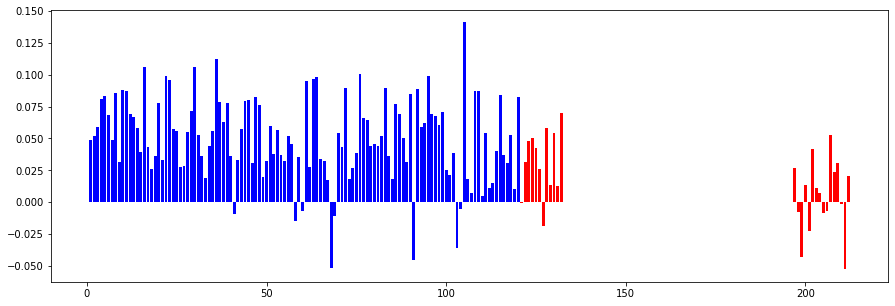

In [344]:
plt.figure(figsize = (15, 5))
plt.bar(train_corrs.index, train_corrs.values, color='b')
plt.bar(val_corrs.index, val_corrs.values, color='r')

## Does grouped correlation extend to total correlation of dataset?
- Yes - generally the overall spearman correlation goes with the era grouped average correlation 
- Probably want to confirm this with more testing

In [427]:
train_corrs = training_data.groupby("erano").apply(score)
val_corrs = validation_data.groupby("erano").apply(score)

In [428]:
print(train_corrs.mean(), val_corrs.mean())

0.05080540644118845 0.017569564190877688


In [426]:
training_data[['target', 'prediction']].corr(method='spearman')

,target,prediction
target,1.000000,0.050481
prediction,0.050481,1.000000


In [429]:
validation_data[['target', 'prediction']].corr(method='spearman')

,target,prediction
target,1.000000,0.017423
prediction,0.017423,1.000000


## Lets see if we can improve consistency by doing cross validation across era's 
- each era represents a non overlapping 4 week period of stock performance 
- we want our model to perform well on any time period 
- lets split into era groups for both KFold and TimeSeriesSplit

In [460]:
# Custom TimeSeriesSplitGroups to actually work correctly

class TimeSeriesSplitGroups(_BaseKFold):
    def __init__(self, n_splits=5):
        super().__init__(n_splits, shuffle=False, random_state=None)

    def split(self, X, y=None, groups=None):
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        group_list = np.unique(groups)
        n_groups = len(group_list)
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds ={0} greater"
                 " than the number of samples: {1}.").format(n_folds,
                                                             n_groups))
        indices = np.arange(n_samples)
        test_size = (n_groups // n_folds)
        test_starts = range(test_size + n_groups % n_folds,
                            n_groups, test_size)
        test_starts = list(test_starts)[::-1]
        for test_start in test_starts:
            
            yield (indices[groups.isin(group_list[:test_start])],
                   indices[groups.isin(group_list[test_start:test_start + test_size])])

In [365]:
from sklearn.model_selection import KFold

In [413]:
gcv = KFold(5)

train_era_groups = []
test_era_groups = []
for train, test in gcv.split(training_data[features], training_data[TARGET_NAME], groups=training_data.erano):
    train_era_groups += [training_data.iloc[train].erano.unique()]
    test_era_groups += [training_data.iloc[test].erano.unique()]

In [422]:
test_era_groups

[array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
        47, 48, 49, 50, 51, 52, 53, 54]),
 array([54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
        71, 72, 73, 74, 75, 76]),
 array([76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92,
        93, 94, 95, 96, 97, 98, 99]),
 array([ 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120])]

In [442]:
# Expanding window for training, testing is a static size

gcv = TimeSeriesSplitGroups(5)

train_era_groups = []
test_era_groups = []
for train, test in gcv.split(training_data[features], training_data[TARGET_NAME], groups=training_data.erano):
    train_era_groups += [training_data.iloc[train].erano.unique()]
    test_era_groups += [training_data.iloc[test].erano.unique()]

In [444]:
train_era_groups

[array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
        69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 

### Quick CV test on KFold vs TimeSeriesSplitGroups
- Performs similar, but lets try both

In [42]:
def spearman(y_true, y_pred): 
    return stats.spearmanr(y_pred, y_true).correlation 

In [467]:
clf = lgb.LGBMRegressor(n_estimators=100, max_depth = 2, learning_rate = 0.05, colsample_bytree = 0.1)

corrs_kfold = cross_val_score(
            clf,
            training_data[features],
            training_data[TARGET_NAME],
            cv=KFold(5),
            n_jobs=1,
            groups=training_data.erano,
            scoring=metrics.make_scorer(spearman, greater_is_better=True))

In [468]:
corrs_kfold.std()/corrs_kfold.mean()

0.2856437397448748

In [469]:
clf = lgb.LGBMRegressor(n_estimators=100, max_depth = 2, learning_rate = 0.05, colsample_bytree = 0.1)

corrs_ts = cross_val_score(
            clf,
            training_data[features],
            training_data[TARGET_NAME],
            cv=TimeSeriesSplitGroups(5),
            n_jobs=1,
            groups=training_data.erano,
            scoring=metrics.make_scorer(spearman, greater_is_better=True))

In [470]:
corrs_ts.std()/corrs_ts.mean()

0.28424119232937056

## We want a high average correlation with low standard deviation 
- Lets tune hyper parameters with STD/MEAN on cross validated scores
- This may not be the best option

In [472]:
def hyperopt_KFold(params):
    
    clf = lgb.LGBMRegressor(**params, objective='mse', metric='None')   
    
    corrs_kfold = cross_val_score(
            clf,
            training_data[features],
            training_data[TARGET_NAME],
            cv=KFold(5),
            n_jobs=1,
            groups=training_data.erano,
            scoring=metrics.make_scorer(spearman, greater_is_better=True))
    
    loss = corrs_kfold.std()/corrs_kfold.mean()
    
    return loss

space = {'n_estimators': hp.choice('n_estimators', range(50,5000)),
          'max_depth': hp.choice('max_depth', range(1,6)),
          'colsample_bytree':hp.quniform('colsample_bytree', 0, 1, 0.005),
          'learning_rate': hp.quniform('learning_rate', 0, 0.5, 0.005)
#          , 'subsample': hp.quniform('subsample', 0.05, 0.95, 0.01)
        }

def f(params):
    loss = hyperopt_KFold(params)
    return {'loss': loss, 'status': STATUS_OK}

trials = Trials()

In [473]:
best = fmin(f, space, algo=tpe.suggest, max_evals=25, trials=trials)


  0%|                                                                           | 0/25 [00:00<?, ?trial/s, best loss=?]

2022-05-01 07:50:42,526 INFO hyperopt.tpe: build_posterior_wrapper took 0.216255 seconds
2022-05-01 07:50:42,527 INFO hyperopt.tpe: TPE using 0 trials



  4%|█▊                                           | 1/25 [08:26<3:22:46, 506.92s/trial, best loss: 0.30222575844135624]

2022-05-01 07:59:09,602 INFO hyperopt.tpe: build_posterior_wrapper took 0.341323 seconds
2022-05-01 07:59:09,602 INFO hyperopt.tpe: TPE using 1/1 trials with best loss 0.302226



  8%|███▌                                         | 2/25 [09:09<2:20:55, 367.63s/trial, best loss: 0.18640710599754726]

2022-05-01 07:59:52,101 INFO hyperopt.tpe: build_posterior_wrapper took 0.247027 seconds
2022-05-01 07:59:52,101 INFO hyperopt.tpe: TPE using 2/2 trials with best loss 0.186407



 12%|█████▍                                       | 3/25 [20:07<2:46:45, 454.81s/trial, best loss: 0.18640710599754726]

2022-05-01 08:10:50,299 INFO hyperopt.tpe: build_posterior_wrapper took 0.222438 seconds
2022-05-01 08:10:50,299 INFO hyperopt.tpe: TPE using 3/3 trials with best loss 0.186407



 16%|███████▏                                     | 4/25 [21:35<2:00:41, 344.83s/trial, best loss: 0.18640710599754726]

2022-05-01 08:12:20,582 INFO hyperopt.tpe: build_posterior_wrapper took 2.282737 seconds
2022-05-01 08:12:20,582 INFO hyperopt.tpe: TPE using 4/4 trials with best loss 0.186407



 20%|█████████                                    | 5/25 [59:14<5:06:21, 919.08s/trial, best loss: 0.18640710599754726]

2022-05-01 08:49:57,514 INFO hyperopt.tpe: build_posterior_wrapper took 0.221033 seconds
2022-05-01 08:49:57,514 INFO hyperopt.tpe: TPE using 5/5 trials with best loss 0.186407



 24%|██████████                                | 6/25 [1:23:07<5:39:49, 1073.15s/trial, best loss: 0.18640710599754726]

2022-05-01 09:13:50,158 INFO hyperopt.tpe: build_posterior_wrapper took 0.214029 seconds
2022-05-01 09:13:50,158 INFO hyperopt.tpe: TPE using 6/6 trials with best loss 0.186407



 28%|████████████                               | 7/25 [1:41:54<5:26:46, 1089.23s/trial, best loss: 0.1279782806474897]

2022-05-01 09:32:37,000 INFO hyperopt.tpe: build_posterior_wrapper took 0.331615 seconds
2022-05-01 09:32:37,000 INFO hyperopt.tpe: TPE using 7/7 trials with best loss 0.127978



 32%|█████████████▊                             | 8/25 [2:00:39<5:11:37, 1099.88s/trial, best loss: 0.1279782806474897]

2022-05-01 09:51:21,635 INFO hyperopt.tpe: build_posterior_wrapper took 0.236616 seconds
2022-05-01 09:51:21,635 INFO hyperopt.tpe: TPE using 8/8 trials with best loss 0.127978



 36%|███████████████▊                            | 9/25 [2:09:27<4:07:33, 928.36s/trial, best loss: 0.1279782806474897]

2022-05-01 10:00:09,784 INFO hyperopt.tpe: build_posterior_wrapper took 0.216874 seconds
2022-05-01 10:00:09,784 INFO hyperopt.tpe: TPE using 9/9 trials with best loss 0.127978



 40%|█████████████████▏                         | 10/25 [2:14:46<3:06:25, 745.70s/trial, best loss: 0.1279782806474897]

2022-05-01 10:05:31,346 INFO hyperopt.tpe: build_posterior_wrapper took 2.280403 seconds
2022-05-01 10:05:31,346 INFO hyperopt.tpe: TPE using 10/10 trials with best loss 0.127978



 44%|██████████████████▍                       | 11/25 [2:18:10<2:16:04, 583.17s/trial, best loss: 0.06862129906029786]

2022-05-01 10:08:53,317 INFO hyperopt.tpe: build_posterior_wrapper took 0.343352 seconds
2022-05-01 10:08:53,317 INFO hyperopt.tpe: TPE using 11/11 trials with best loss 0.068621



 48%|████████████████████▏                     | 12/25 [2:25:24<1:56:40, 538.51s/trial, best loss: 0.06862129906029786]

2022-05-01 10:16:07,508 INFO hyperopt.tpe: build_posterior_wrapper took 0.201485 seconds
2022-05-01 10:16:07,524 INFO hyperopt.tpe: TPE using 12/12 trials with best loss 0.068621



 52%|█████████████████████▊                    | 13/25 [2:29:47<1:31:09, 455.77s/trial, best loss: 0.06862129906029786]

2022-05-01 10:20:30,239 INFO hyperopt.tpe: build_posterior_wrapper took 0.235948 seconds
2022-05-01 10:20:30,239 INFO hyperopt.tpe: TPE using 13/13 trials with best loss 0.068621



 56%|███████████████████████▌                  | 14/25 [2:42:58<1:41:58, 556.18s/trial, best loss: 0.06862129906029786]

2022-05-01 10:33:40,698 INFO hyperopt.tpe: build_posterior_wrapper took 0.216317 seconds
2022-05-01 10:33:40,698 INFO hyperopt.tpe: TPE using 14/14 trials with best loss 0.068621



 60%|█████████████████████████▏                | 15/25 [2:47:26<1:18:18, 469.88s/trial, best loss: 0.06862129906029786]

2022-05-01 10:38:10,452 INFO hyperopt.tpe: build_posterior_wrapper took 1.449826 seconds
2022-05-01 10:38:10,452 INFO hyperopt.tpe: TPE using 15/15 trials with best loss 0.068621



 64%|██████████████████████████▉               | 16/25 [3:03:17<1:32:08, 614.30s/trial, best loss: 0.06862129906029786]

2022-05-01 10:54:00,587 INFO hyperopt.tpe: build_posterior_wrapper took 0.307574 seconds
2022-05-01 10:54:00,603 INFO hyperopt.tpe: TPE using 16/16 trials with best loss 0.068621



 68%|████████████████████████████▌             | 17/25 [3:20:38<1:38:57, 742.17s/trial, best loss: 0.06862129906029786]

2022-05-01 11:11:21,107 INFO hyperopt.tpe: build_posterior_wrapper took 0.310734 seconds
2022-05-01 11:11:21,109 INFO hyperopt.tpe: TPE using 17/17 trials with best loss 0.068621



 72%|██████████████████████████████▏           | 18/25 [3:28:59<1:18:09, 669.89s/trial, best loss: 0.06862129906029786]

2022-05-01 11:19:42,253 INFO hyperopt.tpe: build_posterior_wrapper took 0.219792 seconds
2022-05-01 11:19:42,253 INFO hyperopt.tpe: TPE using 18/18 trials with best loss 0.068621



 76%|███████████████████████████████▉          | 19/25 [3:39:48<1:06:21, 663.61s/trial, best loss: 0.06862129906029786]

2022-05-01 11:30:31,206 INFO hyperopt.tpe: build_posterior_wrapper took 0.213989 seconds
2022-05-01 11:30:31,206 INFO hyperopt.tpe: TPE using 19/19 trials with best loss 0.068621



 80%|█████████████████████████████████▌        | 20/25 [3:56:06<1:03:08, 757.74s/trial, best loss: 0.06862129906029786]

2022-05-01 11:46:48,703 INFO hyperopt.tpe: build_posterior_wrapper took 0.326076 seconds
2022-05-01 11:46:48,703 INFO hyperopt.tpe: TPE using 20/20 trials with best loss 0.068621



 84%|████████████████████████████████████▉       | 21/25 [4:06:11<47:28, 712.18s/trial, best loss: 0.06862129906029786]

2022-05-01 11:56:57,072 INFO hyperopt.tpe: build_posterior_wrapper took 2.801731 seconds
2022-05-01 11:56:57,072 INFO hyperopt.tpe: TPE using 21/21 trials with best loss 0.068621



 88%|██████████████████████████████████████▋     | 22/25 [4:12:02<30:11, 603.77s/trial, best loss: 0.06862129906029786]

2022-05-01 12:02:45,284 INFO hyperopt.tpe: build_posterior_wrapper took 0.195425 seconds
2022-05-01 12:02:45,284 INFO hyperopt.tpe: TPE using 22/22 trials with best loss 0.068621



 92%|████████████████████████████████████████▍   | 23/25 [4:15:07<15:55, 477.98s/trial, best loss: 0.06862129906029786]

2022-05-01 12:05:49,766 INFO hyperopt.tpe: build_posterior_wrapper took 0.227782 seconds
2022-05-01 12:05:49,766 INFO hyperopt.tpe: TPE using 23/23 trials with best loss 0.068621



 96%|██████████████████████████████████████████▏ | 24/25 [4:16:29<05:59, 359.19s/trial, best loss: 0.06862129906029786]

2022-05-01 12:07:11,790 INFO hyperopt.tpe: build_posterior_wrapper took 0.233143 seconds
2022-05-01 12:07:11,791 INFO hyperopt.tpe: TPE using 24/24 trials with best loss 0.068621



100%|████████████████████████████████████████████| 25/25 [4:18:25<00:00, 620.23s/trial, best loss: 0.06862129906029786]


In [477]:
best

{'colsample_bytree': 0.025,
 'learning_rate': 0.375,
 'max_depth': 4,
 'n_estimators': 1911}

In [10]:
def correlation_score(y_true, y_pred):
    return 'correlation', stats.spearmanr(y_true, y_pred)[0], True

In [16]:
clf = lgb.LGBMRegressor(n_estimators=best['n_estimators'], max_depth=best['max_depth'], learning_rate=best['learning_rate'], colsample_bytree=best['colsample_bytree'], verbose=5, objective='mse', metric='None')
# clf = lgb.LGBMRegressor(n_estimators=1602, max_depth=5, learning_rate=0.0528, subsample=0.75,colsample_bytree=0.05,reg_lambda=963, verbose=5, objective='mse', metric='None')
clf.fit(training_data[features], training_data[TARGET_NAME], eval_set = [(validation_data[features], validation_data[TARGET_NAME])], eval_metric=correlation_score, early_stopping_rounds=100)

[1]	valid_0's correlation: 0.00731007
Training until validation scores don't improve for 100 rounds
[2]	valid_0's correlation: 0.0141446
[3]	valid_0's correlation: 0.0150931
[4]	valid_0's correlation: 0.0156171
[5]	valid_0's correlation: 0.0132632
[6]	valid_0's correlation: 0.0126377
[7]	valid_0's correlation: 0.0118716
[8]	valid_0's correlation: 0.0112016
[9]	valid_0's correlation: 0.0104403
[10]	valid_0's correlation: 0.013023
[11]	valid_0's correlation: 0.0125996
[12]	valid_0's correlation: 0.0121118
[13]	valid_0's correlation: 0.0130629
[14]	valid_0's correlation: 0.0138394
[15]	valid_0's correlation: 0.0140161
[16]	valid_0's correlation: 0.0139381
[17]	valid_0's correlation: 0.0142975
[18]	valid_0's correlation: 0.0131431
[19]	valid_0's correlation: 0.0129736
[20]	valid_0's correlation: 0.0127882
[21]	valid_0's correlation: 0.0131823
[22]	valid_0's correlation: 0.0123786
[23]	valid_0's correlation: 0.0123076
[24]	valid_0's correlation: 0.0124048
[25]	valid_0's correlation: 0.01299

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.025,
              importance_type='split', learning_rate=0.375, max_depth=4,
              metric='None', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=1911, n_jobs=-1, num_leaves=31,
              objective='mse', random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0, verbose=5)

In [483]:
# training_data = pd.read_csv("./numerai_dataset_"+str(tournament_number)+"/numerai_training_data.csv")
# tournament_data = pd.read_csv("./numerai_dataset_"+str(tournament_number)+"/numerai_tournament_data.csv")

print("Generating predictions")
training_data[PREDICTION_NAME] = clf.predict(training_data[features])
# test_data_clean[PREDICTION_NAME] = model.predict(test_data_clean[feature_names])
tournament_data[PREDICTION_NAME] = clf.predict(tournament_data[features])

# Check the per-era correlations on the training set
train_correlations = training_data.groupby("era").apply(score)
print(f"On training the correlation has mean {train_correlations.mean()} and std {train_correlations.std()}")
print(f"On training the average per-era payout is {payout(train_correlations).mean()}")

# Check the per-era correlations on the validation set
validation_data = tournament_data[tournament_data.data_type == "validation"]
validation_correlations = validation_data.groupby("era").apply(score)
print(f"On validation the correlation has mean {validation_correlations.mean()} and std {validation_correlations.std()}")
print(f"On validation the average per-era payout is {payout(validation_correlations).mean()}")

array_train = []
array_val = []

for feat in tournament_data.columns:
    if feat in features:
        corr = np.corrcoef(training_data[feat], training_data.prediction)[0,1]
        array_train.append(corr)

for feat in tournament_data.columns:
    if feat in features:
        corr = np.corrcoef(tournament_data[feat], tournament_data.prediction)[0,1]
        array_val.append(corr)

print('feature_exposure training ', np.std(array_train))
print('feature_exposure validation ', np.std(array_val))
# tournament_data = tournament_data.reset_index()
# data_path = "C:/Users/Rabe's/Desktop/NUMERAI/"
# tournament_data[['id', PREDICTION_NAME]].to_csv(data_path + TOURNAMENT_NAME + "_submission_"+str(tournament_number)+"_ho_lgbm_w_scaling.csv", index=False)

Generating predictions
On training the correlation has mean 0.10471374168637632 and std 0.025581501049215447
On training the average per-era payout is 0.10471374168637632
On validation the correlation has mean 0.019519065593066653 and std 0.024876579133663486
On validation the average per-era payout is 0.019519065593066653
feature_exposure training  0.06903961109970266
feature_exposure validation  0.07116215398805907


## Not bad - ~2% mean correlation - on roughly monthly data
- ~ 26% yearly return assuming future data is similar to validation data (probably not a good assumption)

In [40]:
#Validation Data
(1+0.019519065593066653)**12

1.261084596275639

In [50]:
# Training Data
(1+0.10471374168637632)**12

3.3036731635902927

<BarContainer object of 28 artists>

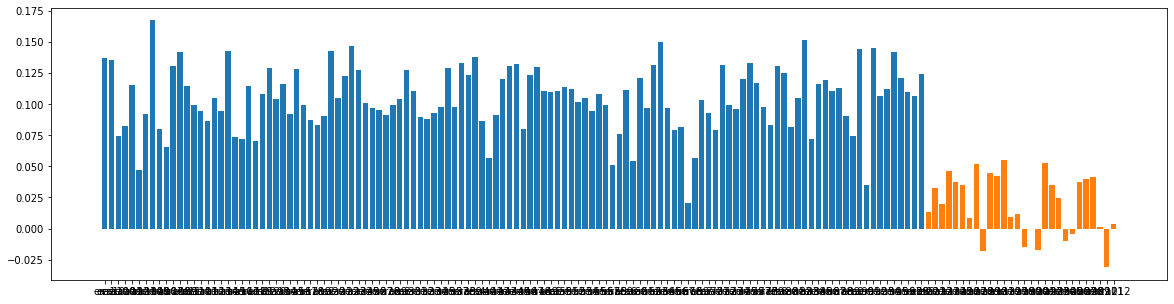

In [485]:
plt.figure(figsize=(20,5))
# correlations = correlations.sort_values()
plt.bar(train_correlations.index, train_correlations.values)
plt.bar(validation_correlations.index, validation_correlations.values)

# Final Thoughts
- Relatively simple model can produce good returns on validation data
- The model hyperparameters were tuned using KFold CV 
- Probably some features that are not helping in the model (possibly remove them?)
- Some era's seems to be challenging to get good correlation - maybe investigate why that is the case - can you mitigate downside?